*Copyright (c) Microsoft Corporation. All rights reserved.*

*Licensed under the MIT License.*



# Understand your NLP models


0. [Methodology](#0-Methodology)

    - 0.1 [Multi-level Quantification](#0.1-Multi-level-Quantification)
    - 0.2 [Perturbation-based Approximation](#0.2-Perturbation-based-Approximation)
    
    
1. [How to understand a simple model](#1-How-to-understand-a-simple-model)

    - 1.1 [Prepare necessary components](#1.1-Prepare-necessary-components)
    - 1.2 [Create an Interpreter instance](#1.2-Create-an-Interpreter-instance)
    - 1.3 [Train the Interpreter](#1.3-Train-the-Interpreter)
    - 1.4 [Show and visualize the results](#1.4-Show-and-visualize-the-results)
    
    
2. [How to understand a saved PyTorch model](#2-How-to-understand-a-saved-PyTorch-model)

    - [2.1 Prepare necessary components](#2.1-Prepare-necessary-components)
    - [2.2 Create an Interpreter instance](#2.2-Create-an-Interpreter-instance)
    - [2.3 Train the Interpreter](#2.3-Train-the-Interpreter)
    - [2.4 Show and visualize the results](#2.4-Show-and-visualize-the-results)

In [1]:
import sys
from tempfile import TemporaryDirectory

sys.path.append("../../")
import json
import torch
import logging
from torch import nn
from urllib import request
import scrapbook as sb
from pytorch_pretrained_bert import BertModel, BertTokenizer

# import utils
from utils_nlp.interpreter.Interpreter import calculate_regularization, Interpreter

# disable the inner message of pytorch_pretrained_bert
logging.getLogger().setLevel(logging.WARNING)

This is a tutorial on how to utilize the `Interpreter` class to explain certain hidden layers in your NLP models. We provide the explanation by measuring the information of input words ${\\bf x}_1$,...,${\\bf x}_n$ that is encoded in hidden state ${\bf s} = \Phi({\bf x})$. 

The method is described in our *ICML 2019* paper: [Towards a Deep and Unified Understanding of Deep Neural Models in NLP](https://www.microsoft.com/en-us/research/publication/towards-a-deep-and-unified-understanding-of-deep-neural-models-in-nlp/).
In this torturial, we provide two examples for you to get started quickly.

## 0 Methodology

We briefly introduce our algorithms here. In short, we are trying to use Mutual Information to understand $\Phi$, the model or layer we want to understand. You can also refer to our paper [here](https://www.microsoft.com/en-us/research/publication/towards-a-deep-and-unified-understanding-of-deep-neural-models-in-nlp/) for more details on algorithm.

### 0.1 Multi-level Quantification

Suppose the input random variable is $\bf X$ and the hidden random variable ${\bf S} = \Phi({\bf X})$. We can provide a global/corpus-level explanation by evaluating the mutual information of $\bf X$ and $\bf S$:

$$MI({\bf X};{\bf S})=H({\bf S}) - H({\bf H}|{\bf S})$$

Where $MI(\cdot;\cdot)$ is the mututal information. $H(\cdot)$ stands for entropy. Because $H({\bf S})$ is a constant only related to input dataset $\bf S$, the only thing we need to consider is $H({\bf H}|{\bf S})$. This conditional entropy can be seen as the global/corpus-level information loss when r.v. $\bf X$ is processed by $\Phi$. By definition:

$$H({\bf X}|{\bf S}) = \int_{{\bf s}\in {\bf S}}p({\bf S})H({\bf X}|{\bf s})d{\bf s}$$

Then, we can decompose the corpus-level information loss to sentence-level:

$$H({\bf X}|{\bf s}) = \int_{{\bf x'}\in {\bf X}}p({\bf x}'|{\bf s})H({\bf x}'|{\bf s})d{\bf x}'$$

If we make an assumption that the inputs of $\Phi$ are independent, we can further decompose the sentence-level information loss to word level:

$$H({\bf X}|{\bf s}) = \sum_i H({\bf X}_i|{\bf s})$$
$$H({\bf X}_i|{\bf s}) = \int_{{\bf x'}_i\in {\bf X}_i}p({\bf x}_i'|{\bf s})H({\bf x}_i'|{\bf s})d{\bf x}_i'$$

Note that $H({\bf X}_i|{\bf s})$ stands for the information loss when word ${\bf x}_i$ reaches hidden state $s$. Therefore, we can use this value as our explanation. Higher value stands for the information of corresponding word is largely lost, which means that this word is less important to $\bf s$, and vice versa.

### 0.2 Perturbation-based Approximation

In order to calculate $H({\bf X}_i|{\bf s})$, we propose a perturbation-besed method. Let $\tilde{\bf x}_{i}={\bf x}_{i} +{\boldsymbol \epsilon}_{i}$ denote an input with a certain noise $\boldsymbol{\epsilon}_{i}$. We assume that the noise term is a random variable that follows a Gaussian distribution, ${\boldsymbol{\epsilon}_{i}}\in \mathbb{R}^{K}$ and ${\boldsymbol \epsilon}_i\sim{\mathcal N}({\bf0},{\boldsymbol\Sigma}_{i}=\sigma_{i}^2{\bf I})$. 
In order to approximate $H({\bf X}_i|{\bf s})$, we first learn an optimal distribution of ${\boldsymbol{\epsilon}} = [{\boldsymbol{\epsilon}}_1^T, {\boldsymbol \epsilon}_2^T, ..., {\boldsymbol \epsilon}_n^T]^T$ with respect to the hidden state 
${\bf s}$ with the following loss:

$$L({\boldsymbol \sigma})=\mathbb{E}_{{\boldsymbol \epsilon}}\Vert\Phi(\tilde{\bf x})-{\bf s}\Vert^2-\lambda\sum_{i=1}^n H(\tilde{\bf X}_{i}|{\bf s})|_{{\boldsymbol\epsilon}_{i}\sim{\mathcal N}({\bf 0},\sigma_{i}^2{\bf I})}$$

where $\lambda>0$ is a hyper-parameter, ${\boldsymbol \sigma}=[\sigma_1,...,\sigma_n]$, and $\tilde{\bf x} = {\bf x} + \boldsymbol{\epsilon}$. The first term  on the left corresponds to the maximum likelihood estimation (MLE) of the distribution of $\tilde{\bf x}_{i}$ that maximizes $\sum_{i}\sum_{\tilde{\bf x}_{i}}\log p(\tilde{\bf x}_{i}|{\bf s})$, if we consider $\sum_{i}\log p(\tilde{\bf x}_{i}|{\bf s})\propto -\Vert\Phi(\tilde{\bf x})-{\bf s}\Vert^2$. In other words, the first term learns a distribution that generates all potential inputs corresponding to the hidden state ${\bf s}$. The second term on the right encourages a high conditional entropy $H(\tilde{\bf X}_{i}|{\bf s})$, which corresponds to the maximum entropy principle. In other words, the noise $\boldsymbol \epsilon$ needs to enumerate all perturbation directions to reach the representation limit of ${\bf s}$. By minimizing the loss above, we can get the optimal ${\sigma}_i$, then we can get the $H(\tilde{\bf X}_i|{\bf s})$:

$$H(\tilde{\bf X}_{i}|{\bf s})=\frac{K}{2}\log(2\pi e)+K\log\sigma_{i}$$

Then, we can use $H(\tilde{\bf X}_i|{\bf s})$ to approximate $H({\bf X}_i|{\bf s})$. Again, you can refer to our paper [here](https://www.microsoft.com/en-us/research/publication/towards-a-deep-and-unified-understanding-of-deep-neural-models-in-nlp/) for more details on algorithm.

## 1 How to understand a simple model

In this section, we use a simple linear function as an example to help you be familiar with the usage of Interpreter utils.

### 1.1 Prepare necessary components
Suppose the $\Phi$ we need to explain is a simple linear function:
$$\Phi(x)=10 \times x[0] + 20 \times x[1] + 5 \times x[2] - 20 \times x[3] - 10 \times x[4]$$
From the definition of $\Phi$ we can know that, the weights of the 2nd and the 4th elements in input $x$ are the biggest (in abs form), which means that they contributes the most to the results. Therefore, a reasonable explanation should show a similar pattern.

In [2]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda")

# Suppose our input is x, and the sentence is simply "1 2 3 4 5"
x_simple = torch.randn(5, 256) / 100
x_simple = x_simple.to(device)
words = ["1", "2", "3", "4", "5"]

# Suppose our hidden state s = Phi(x), where
# Phi = 10 * word[0] + 20 * word[1] + 5 * word[2] - 20 * word[3] - 10 * word[4]
def Phi_simple(x):
    W = torch.tensor([10.0, 20.0, 5.0, -20.0, -10.0]).to(device)
    return W @ x


# Suppose this is our dataset used for training our models
dataset = [torch.randn(5, 256) / 100 for _ in range(100)]

### 1.2 Create an Interpreter instance

In the following, we'll show you how to calculate the $\sigma_i$ using functions in this library. To explain a certain $\bf x$ and certain $\Phi$, we need to create an Interpreter instance, and pass your $\bf x$, $\Phi$ and regularization term (which is the standard variance of the hidden state r.v. $\bf S$) to it. We also provide a simple function to calculate the regularization term that is needed in this method.

In [3]:
# calculate the regularization term
regularization_simple = calculate_regularization(dataset, Phi_simple, device=device)

# create the interpreter instance
# we recommend you to set hyper-parameter *scale* to 10 * Std[word_embedding_weight]
# 10 * 0.1 in this example
interpreter_simple = Interpreter(
    x=x_simple,
    Phi=Phi_simple,
    regularization=regularization_simple,
    scale=10 * 0.1,
    words=words,
)
interpreter_simple.to(device)

Interpreter()

### 1.3 Train the Interpreter

Then, we need to train our interpreter (by minimizing the loss [here](#0.2-Perturbation-based-Approximation)) to let it find the information loss in each input word ${\bf x}_i$ when they reach hidden state $\bf s$. You can control the iteration and learning rate when training.

In [4]:
# Train the interpreter by optimizing the loss
interpreter_simple.optimize(iteration=5000, lr=0.5, show_progress=True)

100%|██████████| 5000/5000 [00:05<00:00, 976.01it/s] 


### 1.4 Show and visualize the results

After training, we can show the sigma (directly speaking, it is the range that every word can change without changing $\bf s$ too much) we have got. Sigma somewhat stands for the information loss of word ${\bf x}_i$ when it reaches $\bf s$.

In [8]:
# Show the sigma we get
sigma_numbers = interpreter_simple.get_sigma()
sigma_numbers

array([0.00316059, 0.00158621, 0.00629779, 0.00158636, 0.0030826 ],
      dtype=float32)

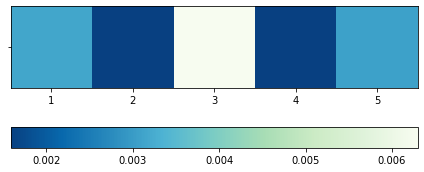

In [9]:
# Visualize the information loss of our sigma
interpreter_simple.visualize()

We can see that the second and forth words are important to ${\bf s} = \Phi({\bf x})$, which is reasonable because the weights of them are larger.

## 2 How to understand a saved PyTorch model

In this section, we will show you how to use our Interpreter in a more complex saved PyTorch model. We use the **3rd layer** of the **pre-trained BERT-base (12 layers) model** for simplicity as an example.

### 2.1 Prepare necessary components
we first load the pre-trained model we need to explain and define the sentence we use in our case. Suppose the sentence we want to study is `rare bird has more than enough charm to make it memorable.`, and the layer we need to explain is the 3rd layer.

In [10]:
# suppose the sentence is as following
text = "rare bird has more than enough charm to make it memorable."

# get the tokenized words.
cache_dir = TemporaryDirectory().name
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", cache_dir=cache_dir)
words = ["[CLS]"] + tokenizer.tokenize(text) + ["[SEP]"]

# load BERT base model
model = BertModel.from_pretrained("bert-base-uncased", cache_dir=cache_dir).to(device)
for param in model.parameters():
    param.requires_grad = False
model.eval()

# get the x (here we get x by hacking the code in the pytorch_pretrained_bert package)
tokenized_ids = tokenizer.convert_tokens_to_ids(words)
segment_ids = [0 for _ in range(len(words))]
token_tensor = torch.tensor([tokenized_ids], device=device)
segment_tensor = torch.tensor([segment_ids], device=device)
x_bert = model.embeddings(token_tensor, segment_tensor)[0]

# extract the Phi we need to explain, suppose the layer we are interested in is layer 3
def generate_BERT_Phi(bert_model: BertModel, layer: int):
    assert (
        1 <= layer <= 12
    ), "model only have 12 layers, while you want to access layer %d" % (layer)

    def Phi(x):
        x = x.unsqueeze(0)
        attention_mask = torch.ones(x.shape[:2]).to(x.device)
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(dtype=torch.float)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        # extract the 3rd layer
        model_list = bert_model.encoder.layer[:layer]
        hidden_states = x
        for layer_module in model_list:
            hidden_states = layer_module(hidden_states, extended_attention_mask)
        return hidden_states[0]

    return Phi


Phi_bert = generate_BERT_Phi(model, layer=3)

100%|██████████| 407873900/407873900 [00:12<00:00, 32166694.25B/s]


### 2.2 Create an Interpreter instance

In the following, we'll show you how to calculate the $\sigma_i$ using functions in this library. To explain a certain $\bf x$ and certain $\Phi$, we need to create an Interpreter instance, and pass your $\bf x$, $\Phi$ and regularization term (which is the standard variance of the hidden state r.v. $\bf S$) to it. Here, we use the regularization term we already calculated for simplicity.

In [11]:
# here, we load the regularization we already calculated for simplicity
data = request.urlopen("https://nlpbp.blob.core.windows.net/data/regular.json").read()
regularization_bert = json.loads(data)
print(regularization_bert)

[0.6720064191778069, 0.5696053129989517, 0.5447734704199672, 0.5538335568288567, 0.6839598078248833, 0.6505799523747332, 0.6138378727376542, 0.6199456982157656, 0.6306355030517169, 0.5243086318591497, 0.5000930128511534, 0.4827939168590007, 0.51908702631163, 0.5422031857051318, 0.558117971090347, 0.5384989781528138, 0.4973997679961822, 0.5335898308359087, 0.6593399660006478, 0.6181028809756937, 0.6041363265472766, 0.5372477429375551, 0.598196971464808, 0.6076224088069293, 0.5076913720444645, 0.645040330374062, 0.4911672467247289, 0.6188230685389587, 0.500837794378735, 0.609637156019712, 0.6584791082546065, 0.5070865130054582, 0.5897822361246311, 0.6407670325047011, 0.6215270116703064, 0.5588143832710171, 0.6331066296213183, 0.5231979565110525, 0.5658921746881577, 0.5968348697164344, 0.6109241047763923, 0.6946546444303081, 0.6124973128849484, 0.5661205470990824, 0.6209094314251753, 0.5050536927131517, 0.9198743437277025, 0.6441395669510548, 0.6859488332096185, 0.601743328628138, 0.66577

In [12]:
interpreter_bert = Interpreter(
    x=x_bert, Phi=Phi_bert, regularization=regularization_bert, words=words
).to(device)

### 2.3 Train the Interpreter

Then, we need to train our interpreter (by minimizing the loss [here](#0.2-Perturbation-based-Approximation)) to let it find the information loss in each input word ${\bf x}_i$ when they reach hidden state $\bf s$. You can control the iteration and learning rate when training.

In [13]:
interpreter_bert.optimize(iteration=5000, lr=0.01, show_progress=True)

100%|██████████| 5000/5000 [00:58<00:00, 85.92it/s]


### 2.4 Show and visualize the results

After training, we can show the sigma (directly speaking, it is the range that every word can change without changing $\bf s$ too much) we have got. Sigma somewhat stands for the information loss of word ${\bf x}_i$ when it reaches $\bf s$.

In [14]:
sigma_bert = interpreter_bert.get_sigma()
sigma_bert

array([0.17860198, 0.14068164, 0.15262878, 0.22471362, 0.20457381,
       0.21281476, 0.18869533, 0.13970219, 0.25510186, 0.22200805,
       0.24051382, 0.1302286 , 0.2824908 , 0.36167043], dtype=float32)

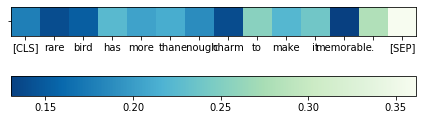

In [15]:
interpreter_bert.visualize()

We can see that the word 'rare', 'bird', 'charm', 'memorable' is important to the third layer.

In [19]:
# for testing
sb.glue("sigma_numbers", list(sigma_numbers))
sb.glue("sigma_bert", list(sigma_bert))